In [75]:
import geopandas as gpd
%matplotlib inline
import shapely
from geomet import wkt
import geojson

import pandas as pd
import numpy as np
import urllib.request
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import matplotlib.image as mpimg
from os import listdir
import datetime as dt
import geopandas as gpd
import time
from os import listdir
%matplotlib inline
import pickle
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

Read Test data

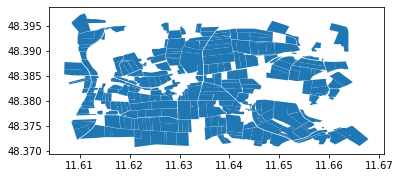

In [76]:
fp = r"../data/cropdata/Test_area.shp"
gpd_frame = gpd.read_file(fp)

gpd_frame.plot()

Nutz_ant lists all crop names in German. We summarized eqaul crop types

In [77]:
df=gpd_frame.copy()
df.NC_ant = df.NC_ant.astype(str).astype(int)
df.loc[(df.NC_ant == 601)|(df.NC_ant == 602), 'NC_ant'] = 600  #Potato
df.loc[(df.NC_ant == 131)|(df.NC_ant == 476), 'NC_ant'] = 131  #Winter barley
df.loc[(df.NC_ant == 411)|(df.NC_ant == 171)|(df.NC_ant == 410)|(df.NC_ant == 177), 'NC_ant'] = 400  #Corn
df.loc[(df.NC_ant == 311)|(df.NC_ant == 489), 'NC_ant'] = 311  #Winter rapeseed
#WW = 115
#ZR = 603
df.loc[~((df.NC_ant == 600)|(df.NC_ant == 131)|(df.NC_ant == 400)|(df.NC_ant == 311)|(df.NC_ant == 115)|(df.NC_ant == 603)), 'NC_ant'] = 1  #rejection class Other

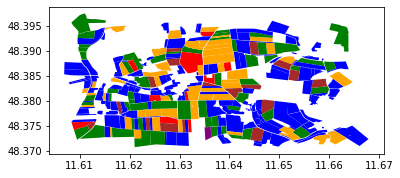

In [78]:
df.loc[(df.NC_ant == 600), 'Color'] = "purple" 
df.loc[(df.NC_ant == 400), 'Color'] = "orange"
df.loc[(df.NC_ant == 115), 'Color'] = "green"
df.loc[(df.NC_ant == 311), 'Color'] = "red"
df.loc[(df.NC_ant == 603), 'Color'] = "pink"
df.loc[(df.NC_ant == 131), 'Color'] = "brown"
df.loc[(df.NC_ant == 1), 'Color'] = "blue"
df.plot(column='NC_ant',color=df["Color"])

In [79]:
#assign crop types to values
df.loc[(df.NC_ant == 600), 'CropType'] = "Potatoes" 
df.loc[(df.NC_ant == 400), 'CropType'] = "Corn"
df.loc[(df.NC_ant == 115), 'CropType'] = "Winter wheat"
df.loc[(df.NC_ant == 311), 'CropType'] = "Winter rapeseed"
df.loc[(df.NC_ant == 603), 'CropType'] = "Sugar beets"
df.loc[(df.NC_ant == 131), 'CropType'] = "Winter barley"
df.loc[(df.NC_ant == 1), 'CropType'] = "Other"

#change NC_ant to NC
df.rename(columns={'NC_ant': 'NC'}, inplace=True)

In [80]:
# load the model 2016-2018
filename='../model/model_RF_bands_161718_withoutother.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [82]:
# load the satellite data for our gpd_frame
test_area = pd.read_excel('../data/sentinel-2/TestData.xlsx', index_col=0)

In [83]:
#adapt the crop type code like described
test_area.NC = test_area.NC.astype(str).astype(int)
test_area.loc[(test_area.NC == 410), 'NC'] = 400  #Corn
test_area.loc[~((test_area.NC == 600)|(test_area.NC == 131)|(test_area.NC == 400)|(test_area.NC == 311)|(test_area.NC == 115)|(test_area.NC == 603)), 'NC'] = 1  #rejection class other

#delete all fields with 1 / The loaded model is trained without rejection class other
test_area = test_area[test_area.NC != 1]

#data for input / The loaded model was trained with bands as features
band = "_B"
X = test_area[test_area.columns[test_area.columns.str.contains(band,na=False)]]
y = test_area['NC']

#predict label
y_pred = loaded_model.predict(X=X)

#Accuracy
print("Accuracy", sklearn.metrics.accuracy_score(y,loaded_model.predict(X=X)))
print('Accuracy of classifier on training set: {:.2f}'
     .format(loaded_model.score(X, y)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(loaded_model.score(X, y)))

Accuracy 0.9624060150375939
Accuracy of classifier on training set: 0.96
Accuracy of classifier on test set: 0.96


In [84]:
# delete class other and assign predicitions
df = df[df.NC !=1]

df.Pred = 0
df = df.assign(Pred=y_pred)

df.loc[(df.Pred == 600), 'Color_pred'] = "purple" 
df.loc[(df.Pred == 400), 'Color_pred'] = "orange"
df.loc[(df.Pred == 115), 'Color_pred'] = "green"
df.loc[(df.Pred == 311), 'Color_pred'] = "red"
df.loc[(df.Pred == 603), 'Color_pred'] = "pink"
df.loc[(df.Pred == 131), 'Color_pred'] = "brown"
#df.loc[(df.Pred == 1), 'Color_pred'] = "blue"

#add difference
df['Diff'] = df.NC - df.Pred
df_diff = df[df.Diff != 0]


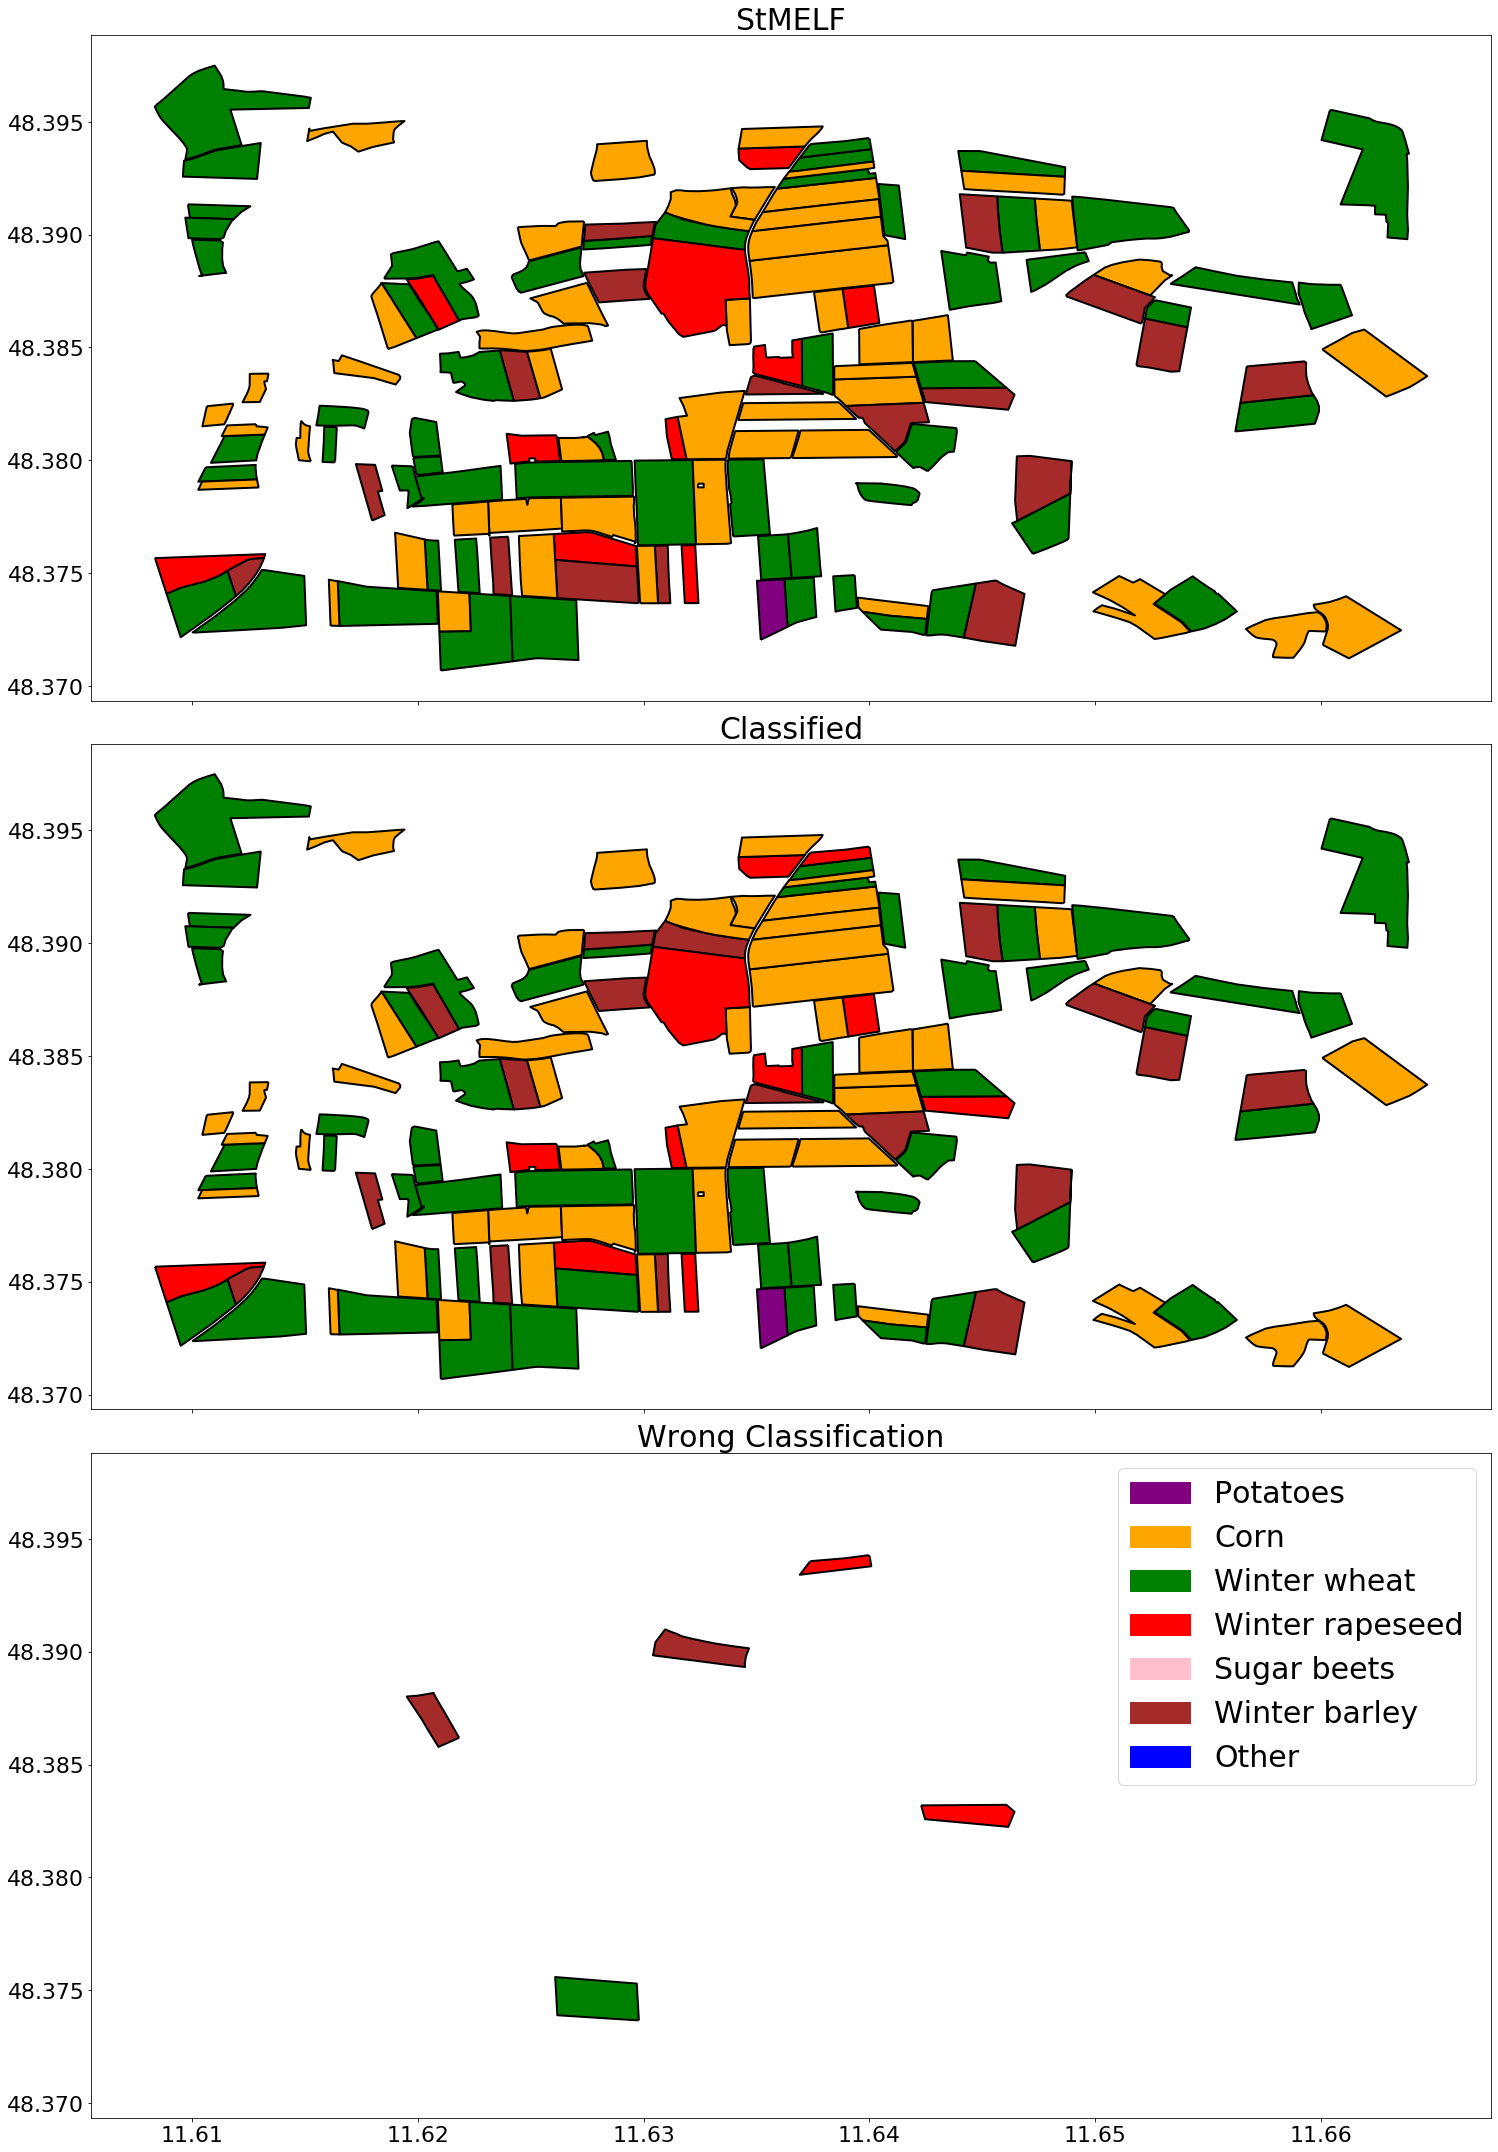

In [85]:
#plot results

fig,axarr = plt.subplots(3,1,figsize=(30,30),sharex=True,sharey=True)
size=22
size2=30
axarr[0] = df.plot(axes=axarr[0],column='NC',color=df["Color"], label=df["CropType"],linewidth=2, edgecolor="black")
#axarr[0,0].axis('off')
axarr[0].set_title("StMELF", y= 0.7, fontsize=size2)
axarr[1].set_title("Classified", y= 0.7, fontsize=size2)
axarr[1] = df.plot(axes=axarr[1],column='Pred',color=df["Color_pred"],label=df["CropType"],linewidth=2, edgecolor="black",facecolor='green')
axarr[2].set_title("Wrong Classification", y= 0.7, fontsize=size2)
axarr[2] = df_diff.plot(axes=axarr[2],column='Pred',color=df_diff["Color_pred"],label=df_diff["CropType"],linewidth=2, edgecolor="black",facecolor='green')


colors = {"Potatoes":"purple", "Corn":"orange","Winter wheat":"green","Winter rapeseed":"red","Sugar beets":"pink","Winter barley":"brown","Other":"blue"}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels,fontsize=size2,fancybox=True)

plt.setp(axarr[0].get_xticklabels(), fontsize=size)
plt.setp(axarr[0].get_yticklabels(), fontsize=size)
plt.setp(axarr[1].get_xticklabels(), fontsize=size)
plt.setp(axarr[1].get_yticklabels(), fontsize=size)
plt.setp(axarr[2].get_xticklabels(), fontsize=size)
plt.setp(axarr[2].get_yticklabels(), fontsize=size)
plt.tight_layout()
plt.show()

In [86]:
fig.savefig("../docs/croptype.png", pad_inches=0)